In [36]:
% matplotlib inline
# base modules
import os
import pickle
from datetime import datetime
import csv
# downloaded modules
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import theano
import theano.tensor as T
import lasagne
import time

In [2]:
def load_data(fname='norm_faces.pkl'):
    with open(fname,'rb') as pk:
        return pickle.load(pk)

In [11]:
train_data, train_labels, test_data = load_data()

In [31]:
def plotface(data, labels, n=0):
    plt.imshow(data[n].reshape(96,96), cmap='gray')
    for i, crd in enumerate([ labels[n][i:i+2]*96 for i in xrange(0,len(labels[n]),2) ]):
    #     print i, crd
        if i == 0:
            plt.plot(crd[0], crd[1], 'r.')
        elif i == 1:
            plt.plot(crd[0], crd[1], 'y.')
        else:
            plt.plot(crd[0], crd[1], 'c.')
    plt.draw()

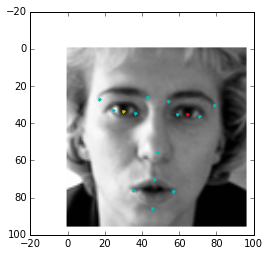

In [32]:
plotface(train_data, train_labels, n=1)

In [90]:
def output_for_kaggle(predictions, fdir='submissions'):
    submission_format = pd.read_csv('dataraw/IdLookupTable.csv').iloc[:,1:3]
    
    outname = os.path.join(fdir, 'submission-%s.csv' % datetime.now().strftime('%Y%m%d%H%M%S') )
    predictions = predictions*96
    predictions[predictions]
    if np.any(predictions > 96):
        print predictions[np.where(predictions > 96)]
        print np.where(predictions > 96)
        raise Exception('over96')
    
    
    out = pd.DataFrame(predictions)
    out.columns = [u'left_eye_center_x', u'left_eye_center_y', u'right_eye_center_x',
       u'right_eye_center_y', u'left_eye_inner_corner_x',
       u'left_eye_inner_corner_y', u'left_eye_outer_corner_x',
       u'left_eye_outer_corner_y', u'right_eye_inner_corner_x',
       u'right_eye_inner_corner_y', u'right_eye_outer_corner_x',
       u'right_eye_outer_corner_y', u'left_eyebrow_inner_end_x',
       u'left_eyebrow_inner_end_y', u'left_eyebrow_outer_end_x',
       u'left_eyebrow_outer_end_y', u'right_eyebrow_inner_end_x',
       u'right_eyebrow_inner_end_y', u'right_eyebrow_outer_end_x',
       u'right_eyebrow_outer_end_y', u'nose_tip_x', u'nose_tip_y',
       u'mouth_left_corner_x', u'mouth_left_corner_y', u'mouth_right_corner_x',
       u'mouth_right_corner_y', u'mouth_center_top_lip_x',
       u'mouth_center_top_lip_y', u'mouth_center_bottom_lip_x',
       u'mouth_center_bottom_lip_y']
    out['ImageId'] = range(1,out.shape[0]+1,1)
    out_long = pd.melt(out, id_vars = ['ImageId'], var_name = 'FeatureName', value_name = 'Location')
    
    sub = pd.merge(submission_format, out_long, how='left', on=['ImageId','FeatureName'])
    sub = sub.iloc[:,2]
    sub.index = range(1,sub.shape[0]+1,1)
    sub.index.name = 'RowId'
    sub.to_csv(outname, header=['Location'])

### Your Run of the Mill Neural Network

Defined in Lasagne with 1 hidden layer (300 nodes, densely connected)

In [7]:
# helper function via https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py, line 289
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
	assert len(inputs) == len(targets)
	if shuffle:
		indices = np.arange(len(inputs))
		np.random.shuffle(indices)
	for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
		if shuffle:
			excerpt = indices[start_idx:start_idx + batchsize]
		else:
			excerpt = slice(start_idx, start_idx + batchsize)
		yield inputs[excerpt], targets[excerpt]

In [61]:
# Set Up Network with 1 Hidden Layer (300 nodes, densely connected)
def basic_network(input_var = None):
	net = lasagne.layers.InputLayer(shape=(None, 1, 96, 96), input_var=input_var)
	net = lasagne.layers.DenseLayer(net, num_units=300)
	net = lasagne.layers.DenseLayer(net,
		num_units=30)	
	return net

In [50]:
def run_nn(network, outname, train_x, train_y, val_x, val_y, test_x, num_epochs=1000, learning_rate=.01, momentum=.09, showy=False):
    input_var = T.tensor4('inputs')
    target_var = T.fmatrix('targets')
    print 'Building model and compiling functions'
    network = network(input_var)
    print 1
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    loss = loss.mean()
    print 2
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=learning_rate, momentum=momentum)
    print 3
    test_prediction=lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction, target_var)
    test_loss = test_loss.mean()
    print 'Compiling training function'
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)
    print 'Compiling validation and test functions'
    val_fn = theano.function([input_var, target_var], test_loss)#, allow_input_downcast=True)
    test_fn = theano.function([input_var], test_prediction)
    
    train_accuracies = []
    val_accuracies = []
    try: # TRAINING!
        for epoch in range(num_epochs):
            # In each epoch, we do a full pass over the training data:
            train_err = 0
            train_batches = 0
            start_time = time.time()
            for batch in iterate_minibatches(train_x, train_y, 200, shuffle=True):
                inputs, targets = batch
                train_err += train_fn(inputs, targets)
                train_batches += 1

            val_err = 0
            val_batches = 0
            for batch in iterate_minibatches(val_x, val_y, 50, shuffle=False):
                inputs, targets = batch
                err = val_fn(inputs, targets)
                val_err += err
                val_batches += 1

            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            tloss = train_err / train_batches
            vloss = val_err / val_batches
            train_accuracies.append(tloss)
            val_accuracies.append(vloss)
            print("  training loss:\t\t{:.6f}".format(tloss))
            print("  validation loss:\t\t{:.6f}".format(vloss))
            n = 1
            results = test_fn( test_x[n:n+2] )
            if showy:
                plt.clf()
                plotface(test_x, results)

    except KeyboardInterrupt:
        pass
    
    print 'saving model'
    with open(outname + 'model.pkl','wb') as out2:
        params = lasagne.layers.get_all_params(network)
        pickle.dump(params, out2)

    print 'saving test results'
    results = None
    for d in xrange(0,test_x.shape[0], 100):
        testsmall = test_x[d:d+100]
        out = test_fn(testsmall)
        if results is not None:
            results = np.concatenate((results, out), axis=0)
        else:
            results = out
    with open(outname + 'results.pkl','wb') as out:
        pickle.dump(results, out)
    with open(outname + 'training_curve.pkl','wb') as out:
        pickle.dump((train_accuracies, val_accuracies), out)
    print 'Done!'

(2140, 1, 96, 96)
(1783, 1, 96, 96)
Building model and compiling functions
1
2
3
Compiling training function
Compiling validation and test functions
Epoch 1 of 1000 took 0.321s
  training loss:		0.174244
  validation loss:		0.159674
Epoch 2 of 1000 took 0.241s
  training loss:		0.133583
  validation loss:		0.126095
Epoch 3 of 1000 took 0.237s
  training loss:		0.117922
  validation loss:		0.119252
Epoch 4 of 1000 took 0.232s
  training loss:		0.106504
  validation loss:		0.108840
Epoch 5 of 1000 took 0.217s
  training loss:		0.103503
  validation loss:		0.107024
Epoch 6 of 1000 took 0.183s
  training loss:		0.101355
  validation loss:		0.104701
Epoch 7 of 1000 took 0.179s
  training loss:		0.099393
  validation loss:		0.102194
Epoch 8 of 1000 took 0.184s
  training loss:		0.088144
  validation loss:		0.085080
Epoch 9 of 1000 took 0.183s
  training loss:		0.079872
  validation loss:		0.081050
Epoch 10 of 1000 took 0.182s
  training loss:		0.072084
  validation loss:		0.075091
Epoch 11 o

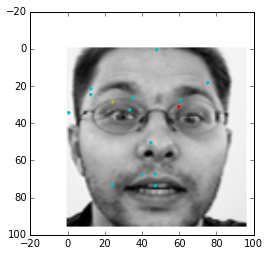

In [55]:
def main(train_data = train_data, test_data = test_data):
    
    train_data = train_data.reshape(-1, 1, 96, 96)
    test_data = test_data.reshape(-1, 1, 96, 96)
    print train_data.shape
    print test_data.shape

    run_nn(basic_network,
           'basic300',
           train_data[:-200],
           train_labels[:-200], 
           train_data[-200:], 
           train_labels[-200:],
           test_data,
           showy=True, learning_rate=.005)
    
# main()

Best Validation Loss: .0303

This is pretty terrible.

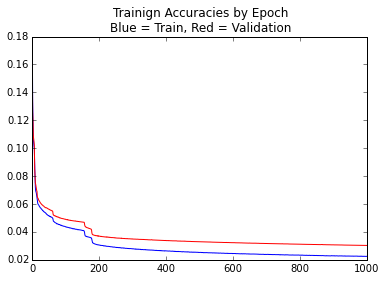

In [58]:
def examine_results(fname='basic300training_curve.pkl'):
    with open(fname, 'rb') as fin:
        results = pickle.load(fin)
    plt.plot(results[0])
    plt.plot(results[1],'r-')
    plt.title('Trainign Accuracies by Epoch\nBlue = Train, Red = Validation')
    plt.show()
examine_results()

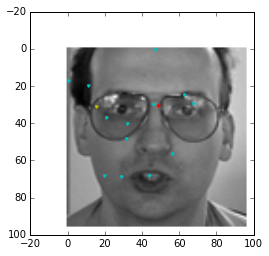

In [59]:
with open('basic300results.pkl', 'rb') as fin:
    results = pickle.load(fin)
    
plotface(train_data, results, n=6)

In [65]:
# Set Up Network with 1 Hidden and 50% dropout layer (300 nodes, densely connected)
def basic_drop_network(input_var = None):
    net = lasagne.layers.InputLayer(shape=(None, 1, 96, 96), input_var=input_var)
    net = lasagne.layers.DenseLayer(net, num_units=300)
    net = lasagne.layers.DropoutLayer(net, p=.5)
    net = lasagne.layers.DenseLayer(net, num_units=30)
    return net

(2140, 1, 96, 96)
(1783, 1, 96, 96)
Building model and compiling functions
1
2
3
Compiling training function
Compiling validation and test functions
Epoch 1 of 1000 took 0.448s
  training loss:		0.241048
  validation loss:		0.181190
Epoch 2 of 1000 took 0.226s
  training loss:		0.191394
  validation loss:		0.136445
Epoch 3 of 1000 took 0.221s
  training loss:		0.159097
  validation loss:		0.099328
Epoch 4 of 1000 took 0.192s
  training loss:		0.135391
  validation loss:		0.082896
Epoch 5 of 1000 took 0.199s
  training loss:		0.116881
  validation loss:		0.074408
Epoch 6 of 1000 took 0.189s
  training loss:		0.107288
  validation loss:		0.066542
Epoch 7 of 1000 took 0.188s
  training loss:		0.100835
  validation loss:		0.062329
Epoch 8 of 1000 took 0.191s
  training loss:		0.097586
  validation loss:		0.061347
Epoch 9 of 1000 took 0.232s
  training loss:		0.094982
  validation loss:		0.058257
Epoch 10 of 1000 took 0.188s
  training loss:		0.091834
  validation loss:		0.056057
Epoch 11 o

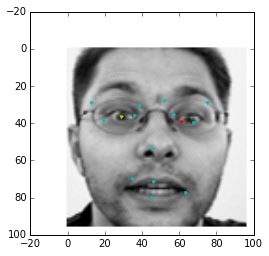

In [70]:
def main(train_data = train_data, test_data = test_data):
    
    train_data = train_data.reshape(-1, 1, 96, 96)
    test_data = test_data.reshape(-1, 1, 96, 96)
    print train_data.shape
    print test_data.shape

    run_nn(basic_drop_network,
           'basic300drop',
           train_data[:-200],
           train_labels[:-200], 
           train_data[-200:], 
           train_labels[-200:],
           test_data,
           showy=True, learning_rate=.005)
    
# main()

Best Validation Loss: .007962

Just by using a drop layer to prevent overfitting, we reduced validation set accuracy by 74%.

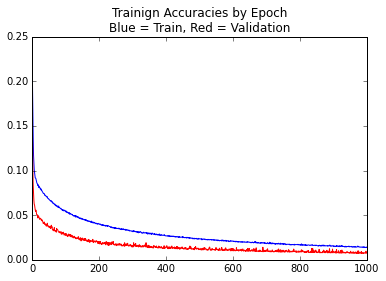

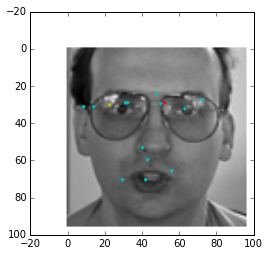

In [72]:
examine_results('basic300droptraining_curve.pkl')
with open('basic300dropresults.pkl', 'rb') as fin:
    results = pickle.load(f in)
    
plotface(train_data, results, n=6)

But the model still doesn't look very good.

In [ ]:
# Set Up Network with 1 Hidden and 50% dropout layer (300 nodes, densely connected)
def basic_2layer_network(input_var = None):
    net = lasagne.layers.InputLayer(shape=(None, 1, 96, 96), input_var=input_var)
    net = lasagne.layers.DenseLayer(net, num_units=300)
    net = lasagne.layers.DenseLayer(net, num_units=300)
    net = lasagne.layers.DenseLayer(net, num_units=30)
    return net

In [75]:
# Set Up Network with 1 Hidden and 50% dropout layer (300 nodes, densely connected)
def basic_2layerdrop_network(input_var = None):
    net = lasagne.layers.InputLayer(shape=(None, 1, 96, 96), input_var=input_var)
    net = lasagne.layers.DenseLayer(net, num_units=300)
    net = lasagne.layers.DropoutLayer(net, p=.5)
    net = lasagne.layers.DenseLayer(net, num_units=300)
    net = lasagne.layers.DropoutLayer(net, p=.5)
    net = lasagne.layers.DenseLayer(net, num_units=30)
    return net

(2140, 1, 96, 96)
(1783, 1, 96, 96)
Building model and compiling functions
1
2
3
Compiling training function
Compiling validation and test functions
Epoch 1 of 1000 took 0.370s
  training loss:		0.232332
  validation loss:		0.192399
Epoch 2 of 1000 took 0.248s
  training loss:		0.177970
  validation loss:		0.133193
Epoch 3 of 1000 took 0.231s
  training loss:		0.157373
  validation loss:		0.116642
Epoch 4 of 1000 took 0.189s
  training loss:		0.147596
  validation loss:		0.107987
Epoch 5 of 1000 took 0.189s
  training loss:		0.141887
  validation loss:		0.101671
Epoch 6 of 1000 took 0.188s
  training loss:		0.139326
  validation loss:		0.097453
Epoch 7 of 1000 took 0.212s
  training loss:		0.134432
  validation loss:		0.096741
Epoch 8 of 1000 took 0.184s
  training loss:		0.132977
  validation loss:		0.094843
Epoch 9 of 1000 took 0.177s
  training loss:		0.129852
  validation loss:		0.094082
Epoch 10 of 1000 took 0.222s
  training loss:		0.129098
  validation loss:		0.087063
Epoch 11 o

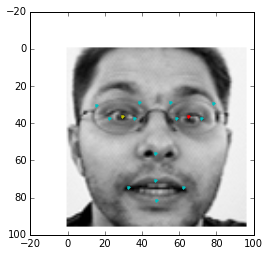

In [78]:
def main(train_data = train_data, test_data = test_data):
    
    train_data = train_data.reshape(-1, 1, 96, 96)
    test_data = test_data.reshape(-1, 1, 96, 96)
    print train_data.shape
    print test_data.shape

    run_nn(basic_2layerdrop_network,
           'basic300twolayerdrop',
           train_data[:-200],
           train_labels[:-200], 
           train_data[-200:], 
           train_labels[-200:],
           test_data,
           showy=True, learning_rate=.01)
    
# main()

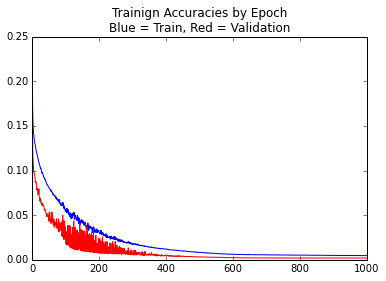

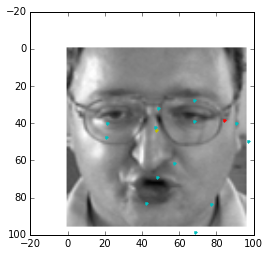

In [96]:
examine_results('basic300twolayerdroptraining_curve.pkl')
with open('basic300twolayerdropresults.pkl', 'rb') as fin:
    results = pickle.load(fin)
    
plotface(train_data, results, n=1007)

Best Validation Loss: .00197

Adding an additional Layer and Drop Layer,
we reduced validation set accuracy by an additional 20%.

The model is starting to look like its getting closer... to the right result

Next up, convolutional layers

In [91]:
# How did we do in Kaggle?
output_for_kaggle(results)

[ 97.18058777  98.59993744]
(array([1007, 1007]), array([ 6, 29]))


Exception: over96

How did we do in Kaggle?